In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
!pip install ipdb

  Stored in directory: /root/.cache/pip/wheels/a8/0e/e2/ffc7bedd430bfd12e9dba3c4dd88906bc42962face85bc4df7
Successfully built ipdb


In [0]:
import numpy as np
import pandas as pd
import ipdb
import pprint
import sys
import matplotlib.pyplot as plt
import math
import operator
import csv
from copy import deepcopy
from tabulate import tabulate

eps = np.finfo(float).eps
from numpy import log2 as log

In [0]:
def standardize_data(X):
    return (X - X.mean())/X.std()

In [0]:
root_path = "/content/gdrive/My Drive/Semester_#2/CSE471_SM_in_AI/Assignments/5/2018201058_assignment5"

In [0]:
data = pd.read_csv(root_path + "/input_data/Apparel/apparel-trainval.csv")

In [0]:
test_data = pd.read_csv(root_path + "/input_data/Apparel/apparel-test.csv")

In [0]:
# removing the output column
data_std = standardize_data(data.iloc[:, 1:])
# data_std = data.iloc[:, 1:]
data_std[["label"]] = data[["label"]]

# msk = np.random.rand(len(data)) < 0.8
# train = X_std[msk].reset_index (drop=True)
# validate = X_std[~msk].reset_index (drop=True)

# Selecting first 80% as Training Data and remaining as Validation Data
train, validate = np.split(data_std, [int(.8*len(data_std))])
validate = validate.reset_index(drop=True)

In [0]:
def one_hot_encoding_get(df):
    labels = list(range(10))
    labels.extend(list(df["label"]))

    s = pd.Series(labels)
    one_hot_encoding = pd.get_dummies(s).values
    return one_hot_encoding[10:, :]

validate_y = one_hot_encoding_get(validate)

In [0]:
def intercept_add(X):
    intercept = np.ones((X.shape[0], 1))
    return np.concatenate((intercept, X), axis=1)

In [0]:
def softmax_(x):
    """Compute the softmax of vector x."""
    # Removing the first column as it is all 1s
    x = x[:, 1:]
#     ipdb.set_trace()
    exps = np.exp(x)
    smax = exps / np.array([np.sum(exps, axis=1)]).T
#     return exps / np.array([np.sum(exps, axis=1)]).T
    return smax

In [0]:
# Activation Functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def relu(x):
    return np.maximum(0, x)

def tanh(x):
    return np.tanh(x)

def stable_softmax(x):
    """Compute the softmax of vector x in a numerically stable way."""
    shift_x = x - np.array([np.max(x, axis=1)]).T
    exps = np.exp(shift_x)
    return exps / np.array([np.sum(exps, axis=1)]).T

In [0]:
# Derivative Functions
def sigmoid_derivative(x):
    return x * (1 - x)

def relu_derivative(x):
    return 1. * (x > 0)

def tanh_derivative(x):
    return (1 - (x ** 2))

In [0]:
def cross_entropy_get(predictions, targets, epsilon=1e-12):
    """
    Computes cross entropy between targets (encoded as one-hot vectors)
    and predictions. 
    Input: predictions (N, k) ndarray
           targets (N, k) ndarray        
    Returns: scalar
    """
    predictions = np.clip(predictions, epsilon, 1. - epsilon)
    N = predictions.shape[0]
    ce = -np.sum(targets * np.log(predictions + 1e-9))/N
    return ce

In [0]:
class NeuralNetwork:
    def __init__(self, num_neurons_list, actn_func = "sigmoid", lr = 0.1, wts = None):
        # initialize HyperParameters
        self.num_neurons_list = deepcopy(num_neurons_list)
        self.num_layers = len(self.num_neurons_list)
        for i in range(self.num_layers-1):
            self.num_neurons_list[i] += 1

        self.num_hidden_layers = self.num_layers - 2
        self.activation_func = actn_func
        self.lr = lr
        
        self.cross_entropies = []
        
        if wts is None:
            self.weights = []
            self.d_weights = []

            for i in range(self.num_layers-1):
                bound = np.sqrt(1./(self.num_neurons_list[i]))
                self.weights.append(np.random.uniform(-bound, bound, (self.num_neurons_list[i], self.num_neurons_list[i+1])))
                self.d_weights.append(np.zeros((self.num_neurons_list[i], self.num_neurons_list[i+1])))
        else:
            for i in range(len(wts)):
                if (self.num_neurons_list[i] != wts[i].shape[0]) or (self.num_neurons_list[i + 1] != wts[i].shape[1]):
                    print ("Weights provided have invalid dimensions!!")
                    sys.exit(-1)
                    
            self.weights = wts


    def forward_prop(self, X):
#         ipdb.set_trace()
        self.L_out = []

        X = intercept_add(X)
        self.L_out.append(X)
        prev_out = None

        for l in range(1, len(self.num_neurons_list)):
            prev_out = self.L_out[-1]
            curr_in = prev_out @ self.weights[l-1]
  
            if l == (len(self.num_neurons_list) - 1):
                curr_out = stable_softmax(curr_in)

            else:
                if self.activation_func == "sigmoid":
                    curr_out = sigmoid(curr_in)
                elif self.activation_func == "relu":
                    curr_out = relu(curr_in)
                elif self.activation_func == "tanh":
                    curr_out = tanh(curr_in)
                else:
                    print ("Invalid Activation Function!!")
                    sys.exit(-1)
                
            self.L_out.append(curr_out)


    def backward_prop(self, y):
#         ipdb.set_trace()
        self.d_weights[-1] = np.dot(self.L_out[-2].T, (2*(y - self.L_out[-1]) * sigmoid_derivative(self.L_out[-1])))

        for i in reversed(range(self.num_layers-2)):
            temp = None
            if self.activation_func == "sigmoid":
                  temp = sigmoid_derivative(self.L_out[i+1])
            elif self.activation_func == "relu":
                temp = relu_derivative(self.L_out[i+1])
            elif self.activation_func == "tanh":
                temp = tanh_derivative(self.L_out[i+1])
            else:
                print ("Invalid Activation Function!!")
                sys.exit(-1)

            self.d_weights[i] = np.dot(self.L_out[i].T,  (np.dot(2*(y - self.L_out[-1]) * sigmoid_derivative(self.L_out[-1]), self.weights[-1].T) * temp))

        for i in range(self.num_layers-1):
            self.weights[i] += (self.lr * self.d_weights[i])


    def fit(self, train_df, batch_size, num_epochs):
        n = len(train_df.index)
        train_y = one_hot_encoding_get(train_df)
        train_x = train_df.iloc[:, :-1].values
        for n_epoch in range(num_epochs):
            epoch_cost = 0.0
            s, e = 0, batch_size
            num_mini_bactches = 0
            while (s < n):
                num_mini_bactches += 1
                
                e = min(n, s + batch_size)

#                 ipdb.set_trace()
                self.forward_prop(train_x[s:e, :])
                self.backward_prop(train_y[s:e, :])

                minibatch_cost = cross_entropy_get(self.L_out[-1], train_y[s:e, :])
                epoch_cost += minibatch_cost

                s = e

            epoch_cost = epoch_cost / num_mini_bactches
            self.cross_entropies.append(epoch_cost)

            if n_epoch % 50 == 0:
                print ("No. of Epochs:", n_epoch, "CrossEntropy:", epoch_cost)


    def predictions_get(self, data_df):
        self.forward_prop(data_df.values)
        return self.L_out[-1].argmax(axis=1)

    def accuracy_get(self, validate_df):
        predictions = self.predictions_get(validate_df.iloc[:, :-1])
        accuracy = 100 * np.mean(predictions == validate_df["label"])
        return round(accuracy, 2)

In [0]:
def error_graph_plot(errors, num_epochs):
    fig, ax = plt.subplots(figsize=(12,6))
    ax.plot(list(range(num_epochs)), errors, color="red", lw=1, ls='-');
    plt.xlabel("Number of Epochs")
    plt.ylabel("Cross Entropy")
    plt.title("Error vs Number of Epochs")
    plt.show()

**Activation Function:** Sigmoid

In [0]:
NN_sigmoid = NeuralNetwork([784, 100, 10], "sigmoid", 0.001)
NN_sigmoid.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 1.1609644345019143
No. of Epochs: 50 CrossEntropy: 0.3079844597591827
No. of Epochs: 100 CrossEntropy: 0.2567220729073486
No. of Epochs: 150 CrossEntropy: 0.22590743668134908
No. of Epochs: 200 CrossEntropy: 0.20615520545918778
No. of Epochs: 250 CrossEntropy: 0.19227382410967217
No. of Epochs: 300 CrossEntropy: 0.18258153279463904
No. of Epochs: 350 CrossEntropy: 0.17448554887514
No. of Epochs: 400 CrossEntropy: 0.16774402044985373
No. of Epochs: 450 CrossEntropy: 0.16265976511331898


In [0]:
sigm_1l_100_001_acc = NN_sigmoid.accuracy_get(validate)
print("Sigmoid Training accuracy:", sigm_1l_100_001_acc, "%")

Sigmoid Training accuracy: 85.91 %


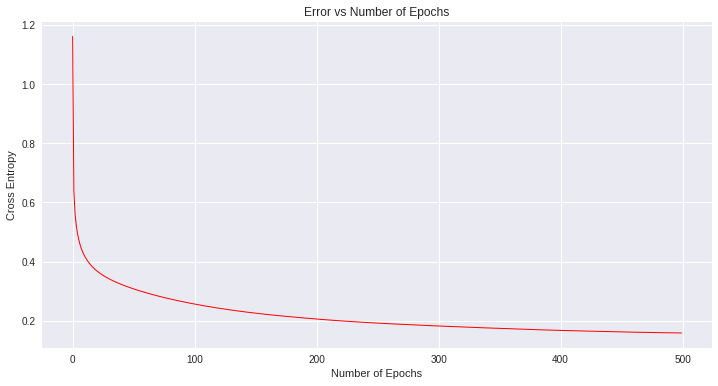

In [0]:
sigm_1l_100_001_errors = NN_sigmoid.cross_entropies
error_graph_plot(sigm_1l_100_001_errors, 500)

In [0]:
NN_sigmoid2 = NeuralNetwork([784, 100, 100, 10], "sigmoid", 0.001)
NN_sigmoid2.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 2.2049578696588217
No. of Epochs: 50 CrossEntropy: 2.3152262701778814
No. of Epochs: 100 CrossEntropy: 0.32902793662876245
No. of Epochs: 150 CrossEntropy: 0.28329157190209425
No. of Epochs: 200 CrossEntropy: 0.25449894065233397
No. of Epochs: 250 CrossEntropy: 0.23407993029412258
No. of Epochs: 300 CrossEntropy: 0.2180630281694392
No. of Epochs: 350 CrossEntropy: 0.2062803470659984
No. of Epochs: 400 CrossEntropy: 0.19689913592284433
No. of Epochs: 450 CrossEntropy: 0.1894445458446401


In [0]:
sigm_2l_100_001_acc = NN_sigmoid2.accuracy_get(validate)
print("Sigmoid Training accuracy:", sigm_2l_100_001_acc, "%")

Sigmoid Training accuracy: 85.84 %


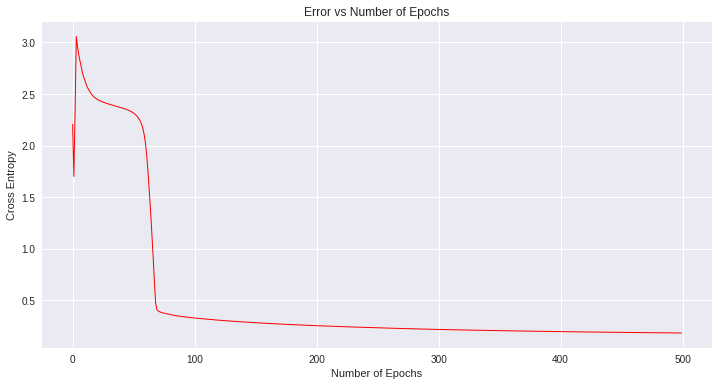

In [0]:
sigm_2l_100_001_errors = NN_sigmoid2.cross_entropies
error_graph_plot(sigm_2l_100_001_errors, len(sigm_2l_100_001_errors))

In [0]:
NN_sigmoid3 = NeuralNetwork([784, 100, 100, 100, 10], "sigmoid", 0.001)
NN_sigmoid3.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 2.303773576193766
No. of Epochs: 50 CrossEntropy: 1.3088603891129929
No. of Epochs: 100 CrossEntropy: 1.3694817672336024
No. of Epochs: 150 CrossEntropy: 1.2999004691185154
No. of Epochs: 200 CrossEntropy: 1.1459946561878873
No. of Epochs: 250 CrossEntropy: 0.9645288636353272
No. of Epochs: 300 CrossEntropy: 0.9319648998441403
No. of Epochs: 350 CrossEntropy: 0.8010336994917102
No. of Epochs: 400 CrossEntropy: 0.6914634283303752
No. of Epochs: 450 CrossEntropy: 0.6276381516555141


In [0]:
sigm_3l_100_001_acc = NN_sigmoid3.accuracy_get(validate)
print("Sigmoid Training accuracy:", sigm_3l_100_001_acc, "%")

Sigmoid Training accuracy: 77.55 %


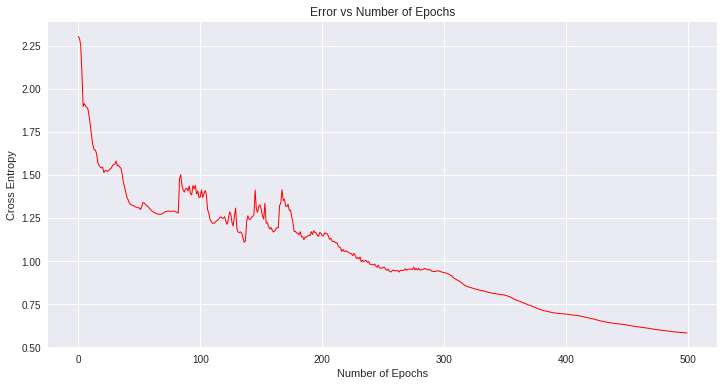

In [0]:
sigm_3l_100_001_errors = NN_sigmoid3.cross_entropies
error_graph_plot(sigm_3l_100_001_errors, len(sigm_3l_100_001_errors))

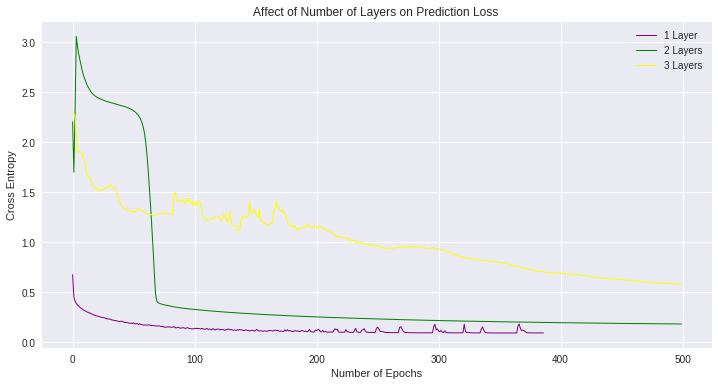

In [0]:
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(list(range(len(sigm_1l_100_001_errors))), sigm_1l_100_001_errors, color="purple", lw=1, ls='-', label="1 Layer")
ax.plot(list(range(len(sigm_2l_100_001_errors))), sigm_2l_100_001_errors, color="green", lw=1, ls='-', label="2 Layers")
ax.plot(list(range(len(sigm_3l_100_001_errors))), sigm_3l_100_001_errors, color="yellow", lw=1, ls='-', label="3 Layers")
plt.xlabel("Number of Epochs")
plt.ylabel("Cross Entropy")
plt.title("Affect of Number of Layers on Prediction Loss ")
plt.legend()
plt.show()

In [0]:
NN_relu1 = NeuralNetwork([784, 100, 10], "relu", 0.001)
NN_relu1.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 0.6766806148694834
No. of Epochs: 50 CrossEntropy: 0.19476941522902835
No. of Epochs: 100 CrossEntropy: 0.14025445870261236
No. of Epochs: 150 CrossEntropy: 0.12010528810545205
No. of Epochs: 200 CrossEntropy: 0.11790135906572569
No. of Epochs: 250 CrossEntropy: 0.1504380341584187
No. of Epochs: 300 CrossEntropy: 0.11367416698795312
No. of Epochs: 350 CrossEntropy: 0.09407262487296085


KeyboardInterrupt: ignored

In [0]:
relu_1l_100_001_acc = NN_relu1.accuracy_get(validate)
print("Sigmoid Training accuracy:", relu_1l_100_001_acc, "%")

Sigmoid Training accuracy: 87.68 %


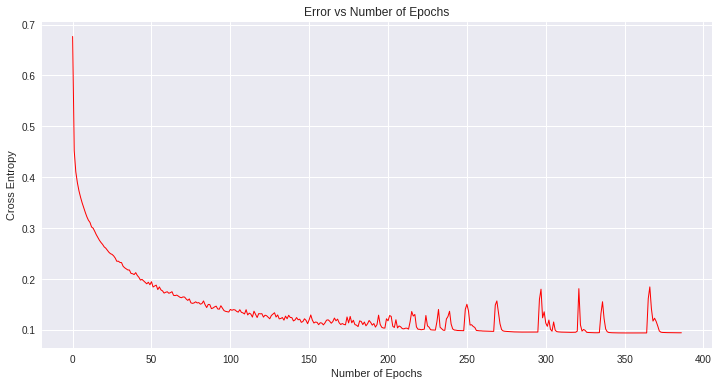

In [0]:
relu_1l_100_001_errors = NN_relu1.cross_entropies
error_graph_plot(relu_1l_100_001_errors, len(relu_1l_100_001_errors))

In [0]:
NN_relu2 = NeuralNetwork([784, 100, 100, 10], "relu", 0.001)
NN_relu2.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 0.9178930215414627
No. of Epochs: 50 CrossEntropy: 0.20202485718747587
No. of Epochs: 100 CrossEntropy: 0.1597195813359471
No. of Epochs: 150 CrossEntropy: 0.1527247564261525
No. of Epochs: 200 CrossEntropy: 0.13492175267028875
No. of Epochs: 250 CrossEntropy: 0.1350236154655996
No. of Epochs: 300 CrossEntropy: 0.13585547100226888
No. of Epochs: 350 CrossEntropy: 0.16443176600966894
No. of Epochs: 400 CrossEntropy: 0.1372592202355497
No. of Epochs: 450 CrossEntropy: 0.13903583817105036


In [0]:
relu_2l_100_001_acc = NN_relu2.accuracy_get(validate)
print("Sigmoid Training accuracy:", relu_2l_100_001_acc, "%")

Sigmoid Training accuracy: 87.31 %


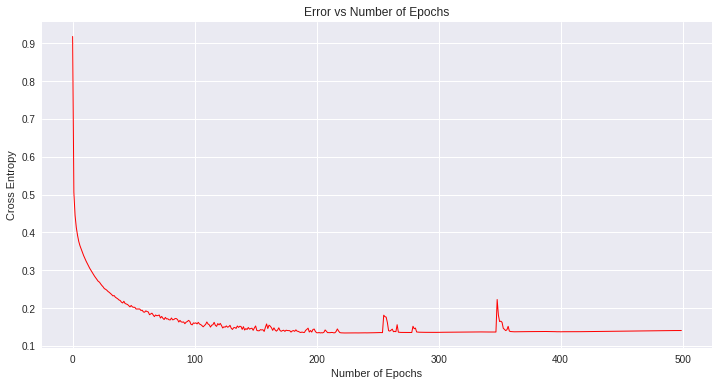

In [0]:
relu_2l_100_001_errors = NN_relu2.cross_entropies
error_graph_plot(relu_2l_100_001_errors, len(relu_2l_100_001_errors))

In [0]:
NN_relu3 = NeuralNetwork([784, 100, 100, 100, 10], "relu", 0.0001)
NN_relu3.fit(train, 500, 500)

No. of Epochs: 0 CrossEntropy: 2.296381153336544
No. of Epochs: 50 CrossEntropy: 0.37028505611384205
No. of Epochs: 100 CrossEntropy: 0.3212143217349637
No. of Epochs: 150 CrossEntropy: 0.290651570627021
No. of Epochs: 200 CrossEntropy: 0.26020974964148064
No. of Epochs: 250 CrossEntropy: 0.2376767901790022
No. of Epochs: 300 CrossEntropy: 0.22228552336076282
No. of Epochs: 350 CrossEntropy: 0.21168131386269481
No. of Epochs: 400 CrossEntropy: 0.2055585069406396
No. of Epochs: 450 CrossEntropy: 0.2004455148693434


In [0]:
# Use the best NN for this
best_predictions = NN_sigmoid.predictions_get(test_data)
best_predictions = [[p] for p in best_predictions]

with open(root_path + '/src/2018201058_prediction.csv', 'w') as csvFile:
    writer = csv.writer(csvFile)
    writer.writerows(best_predictions)

In [0]:
np.save(root_path + '/src/NN_sigmoid_weights', NN_sigmoid.weights)

In [0]:
loaded_wts = np.load(root_path + '/src/NN_sigmoid_weights.npy')
loaded_wts = loaded_wts.tolist()

In [0]:
loaded_NN_sigmoid = NeuralNetwork([784, 500, 10], "sigmoid", 0.00001, loaded_wts)
sigmoid_accuracy = loaded_NN_sigmoid.accuracy_get(validate)
print("Sigmoid Training accuracy:", sigmoid_accuracy, "%")

**Q2. House Price Prediction**

**Steps required to modify the above model for this task**

1. As can be seen the categorical features ‘Alley, ‘PoolQC’, and ‘MscFeature’ have columns missing. However, looking at the data description, the NA’s in categorical variables actually mean “not present”.  For example, NA in the ‘Alley’ variable meant that the home has no alley. To correct the issue, we could replaced the Na’s with “None”. or the remaining numerical features, NA’s could be replaced by the value zero.

2. Turn the categorical data into dummy columns. This involves creating a column for each of the category types within category columns and assigning a 1 or 0 to an entry if the category is met. 
     It could make the dataset become too complex to handle. If it is the case, complexity of the dataset can be reduced by dimensionality reduction tools, like principle component analysis (PCA) and independent component analysis (ICA).

3. Remove the original category columns.

4. As for numerical features, quite a few have a highly skewed distribution which can lead to poor models. To combat this, these features could be log transformed.
